## 05/03/2021

This model was performing well. Will stop the process of optimisation as this has found a better solution, showing that if computing power is available, it is possible to optimise these decision variables through trial and error. 


In [52]:
import torch 
import json 
import numpy as np 
from sklearn.model_selection import train_test_split 
from torch.utils.data import SubsetRandomSampler, DataLoader,TensorDataset
from tqdm import tqdm 
import torch.nn.functional as F
from torch import nn


In [53]:
DATA_PATH = "./data/synthetic/train_data.json"
TEST_PATH = "./data/synthetic/test_data.json"
EPOCHS = 300
BATCH_SIZE = 150
SAVED_MODEL_PATH = "./models/model5.pth"

In [54]:
def load_dataset(data_path):
    with open(data_path,"r") as fp: 
        data = json.load(fp)
    X = np.array(data["data"])
    y = np.array(data["labels"])
    return X, y 

def to_device(data,device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device)for x in data]
    else:
        return data.to(device, non_blocking = True)
    
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl 
        self.device = device 
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
    def __len__(self):
        return len(self.dl)
    
    
X,y=load_dataset(DATA_PATH)
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).float()
dataset = TensorDataset(X,y)
X_test, y_test = load_dataset(TEST_PATH)
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()
testset = TensorDataset(X_test,y_test)

train_dl = DataLoader(dataset, BATCH_SIZE, shuffle = True, drop_last=True)
test_dl = DataLoader(testset, BATCH_SIZE, shuffle = True, drop_last=True)

input_shape = dataset[0][0].shape
device = torch.device('cuda')
train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

In [55]:
print(testset[0][0].shape)
print(type(dataset[0][0]))

torch.Size([1, 128, 16])
<class 'torch.Tensor'>


In [57]:
latent_size = 9
# https://towardsdatascience.com/convolutional-autoencoders-for-image-noise-reduction-32fce9fc1763

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,32,stride = 2, padding=1 , kernel_size=3)
        self.relu = nn.LeakyReLU(0.2)
        self.conv2 = nn.Conv2d(32,64, stride = 2, padding =1, kernel_size=3)
        self.conv3 = nn.Conv2d(64,128,stride =2, padding =1, kernel_size = 3)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(4096,latent_size)
        self.fc = nn.Linear(latent_size,4096)
        self.deconv3 = nn.ConvTranspose2d(128,64,stride =2, kernel_size = 3, padding =1,output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(64,32,stride =2, kernel_size = 3,padding =1,output_padding=1)
        self.deconv1 = nn.ConvTranspose2d(32,1,stride =2, kernel_size = 3,padding =1,output_padding=1)
    
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.relu(out)
        out = self.conv3(out)        
        out = self.relu(out)
        out = self.flatten(out)
        out = self.linear(out)
        out = self.relu(out)
        out = self.fc(out)
        out = self.relu(out)
        out = out.reshape(-1,128,16,2)
        out = self.deconv3(out)
        out = self.relu(out)
        out = self.deconv2(out)
        out = self.relu(out)
        out = self.deconv1(out)
        return out
autoencoder = Autoencoder()
autoencoder.to(device)
autoencoder.load_state_dict(torch.load(SAVED_MODEL_PATH))

<All keys matched successfully>

In [58]:
from torchsummary import summary 
summary(autoencoder, input_size = (1,128,16))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 32, 64, 8]             320
         LeakyReLU-2            [-1, 32, 64, 8]               0
            Conv2d-3            [-1, 64, 32, 4]          18,496
         LeakyReLU-4            [-1, 64, 32, 4]               0
            Conv2d-5           [-1, 128, 16, 2]          73,856
         LeakyReLU-6           [-1, 128, 16, 2]               0
           Flatten-7                 [-1, 4096]               0
            Linear-8                    [-1, 9]          36,873
         LeakyReLU-9                    [-1, 9]               0
           Linear-10                 [-1, 4096]          40,960
        LeakyReLU-11                 [-1, 4096]               0
  ConvTranspose2d-12            [-1, 64, 32, 4]          73,792
        LeakyReLU-13            [-1, 64, 32, 4]               0
  ConvTranspose2d-14            [-1, 32

In [8]:

for images, labels in test_dl: 
    print("spectrogram shape: ", images.shape)
    out = autoencoder(images)
    
    print("output shape: ", out.shape)
    break 
    
img = out[0][0].detach().cpu()
print(img.shape)
import matplotlib.pyplot as plt 

fig, ax = plt.subplots(1,1,figsize = (5,5))
ax.imshow(img, aspect = 'auto')


spectrogram shape:  torch.Size([150, 1, 128, 16])
output shape:  torch.Size([150, 1, 128, 16])
torch.Size([128, 16])


## Now start training and see what the resulting image would look like 


In [8]:
criterion = nn.MSELoss()
ae_opt= torch.optim.Adam(autoencoder.parameters(), lr = 0.0002)


In [9]:
loss_list = []
EPOCHS = 5000
for epoch in range(EPOCHS):
    for i, (images, _) in enumerate(train_dl):
        reconstructed = autoencoder(images)
        loss = criterion(images, reconstructed)
        
        ae_opt.zero_grad()
        loss.backward()
        ae_opt.step()
    
    loss_list.append(np.sum(loss.item()))
    
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, EPOCHS, loss.item()))

        


epoch [1/5000], loss:136.2285
epoch [2/5000], loss:125.8980
epoch [3/5000], loss:110.4861
epoch [4/5000], loss:97.8705
epoch [5/5000], loss:82.2751
epoch [6/5000], loss:71.3083
epoch [7/5000], loss:74.3631
epoch [8/5000], loss:66.1381
epoch [9/5000], loss:57.3965
epoch [10/5000], loss:60.4802
epoch [11/5000], loss:57.0135
epoch [12/5000], loss:53.8916
epoch [13/5000], loss:53.4478
epoch [14/5000], loss:53.4290
epoch [15/5000], loss:57.9321
epoch [16/5000], loss:56.1224
epoch [17/5000], loss:53.7465
epoch [18/5000], loss:54.9006
epoch [19/5000], loss:54.7300
epoch [20/5000], loss:56.3342
epoch [21/5000], loss:60.1308
epoch [22/5000], loss:51.1325
epoch [23/5000], loss:52.5698
epoch [24/5000], loss:50.7041
epoch [25/5000], loss:51.1751
epoch [26/5000], loss:55.8042
epoch [27/5000], loss:50.9367
epoch [28/5000], loss:51.4666
epoch [29/5000], loss:46.5890
epoch [30/5000], loss:52.2464
epoch [31/5000], loss:52.2731
epoch [32/5000], loss:47.3773
epoch [33/5000], loss:44.1372
epoch [34/5000],

epoch [269/5000], loss:30.3181
epoch [270/5000], loss:30.1811
epoch [271/5000], loss:30.5269
epoch [272/5000], loss:30.3778
epoch [273/5000], loss:29.9967
epoch [274/5000], loss:30.0798
epoch [275/5000], loss:29.9638
epoch [276/5000], loss:30.3551
epoch [277/5000], loss:30.1319
epoch [278/5000], loss:30.4161
epoch [279/5000], loss:30.3692
epoch [280/5000], loss:30.4168
epoch [281/5000], loss:30.1896
epoch [282/5000], loss:30.0751
epoch [283/5000], loss:30.0609
epoch [284/5000], loss:30.2957
epoch [285/5000], loss:30.1404
epoch [286/5000], loss:30.3207
epoch [287/5000], loss:29.6021
epoch [288/5000], loss:30.1969
epoch [289/5000], loss:29.7697
epoch [290/5000], loss:30.2235
epoch [291/5000], loss:30.0422
epoch [292/5000], loss:29.7084
epoch [293/5000], loss:30.2318
epoch [294/5000], loss:29.8613
epoch [295/5000], loss:30.1523
epoch [296/5000], loss:29.9553
epoch [297/5000], loss:29.6362
epoch [298/5000], loss:30.1655
epoch [299/5000], loss:30.1824
epoch [300/5000], loss:29.9085
epoch [3

epoch [534/5000], loss:28.8607
epoch [535/5000], loss:28.9208
epoch [536/5000], loss:29.3280
epoch [537/5000], loss:29.1852
epoch [538/5000], loss:29.3843
epoch [539/5000], loss:29.1533
epoch [540/5000], loss:29.2010
epoch [541/5000], loss:29.0669
epoch [542/5000], loss:29.3665
epoch [543/5000], loss:28.7683
epoch [544/5000], loss:29.1196
epoch [545/5000], loss:29.4066
epoch [546/5000], loss:28.8853
epoch [547/5000], loss:28.9945
epoch [548/5000], loss:29.3920
epoch [549/5000], loss:29.1068
epoch [550/5000], loss:29.3590
epoch [551/5000], loss:29.3779
epoch [552/5000], loss:29.2819
epoch [553/5000], loss:29.1922
epoch [554/5000], loss:28.7492
epoch [555/5000], loss:29.6011
epoch [556/5000], loss:28.7539
epoch [557/5000], loss:29.0178
epoch [558/5000], loss:29.1012
epoch [559/5000], loss:28.9673
epoch [560/5000], loss:28.9137
epoch [561/5000], loss:28.7252
epoch [562/5000], loss:29.1708
epoch [563/5000], loss:29.5169
epoch [564/5000], loss:29.0208
epoch [565/5000], loss:29.3908
epoch [5

epoch [799/5000], loss:28.7733
epoch [800/5000], loss:28.4955
epoch [801/5000], loss:28.5751
epoch [802/5000], loss:28.7641
epoch [803/5000], loss:28.3047
epoch [804/5000], loss:28.7853
epoch [805/5000], loss:28.4315
epoch [806/5000], loss:28.3234
epoch [807/5000], loss:28.3162
epoch [808/5000], loss:29.0312
epoch [809/5000], loss:28.5911
epoch [810/5000], loss:28.7081
epoch [811/5000], loss:28.2959
epoch [812/5000], loss:28.6275
epoch [813/5000], loss:28.7633
epoch [814/5000], loss:28.1816
epoch [815/5000], loss:28.6918
epoch [816/5000], loss:28.8546
epoch [817/5000], loss:28.4865
epoch [818/5000], loss:28.3601
epoch [819/5000], loss:28.4787
epoch [820/5000], loss:28.3194
epoch [821/5000], loss:28.4749
epoch [822/5000], loss:28.6337
epoch [823/5000], loss:28.5511
epoch [824/5000], loss:28.4963
epoch [825/5000], loss:28.5988
epoch [826/5000], loss:28.2897
epoch [827/5000], loss:28.8650
epoch [828/5000], loss:28.3358
epoch [829/5000], loss:28.6407
epoch [830/5000], loss:28.1978
epoch [8

epoch [1062/5000], loss:28.1456
epoch [1063/5000], loss:28.1884
epoch [1064/5000], loss:28.1130
epoch [1065/5000], loss:27.8315
epoch [1066/5000], loss:28.0630
epoch [1067/5000], loss:28.0418
epoch [1068/5000], loss:28.3065
epoch [1069/5000], loss:27.8262
epoch [1070/5000], loss:28.4306
epoch [1071/5000], loss:28.2676
epoch [1072/5000], loss:28.2141
epoch [1073/5000], loss:28.6749
epoch [1074/5000], loss:28.3382
epoch [1075/5000], loss:28.0762
epoch [1076/5000], loss:28.0969
epoch [1077/5000], loss:27.9795
epoch [1078/5000], loss:28.0932
epoch [1079/5000], loss:27.7947
epoch [1080/5000], loss:27.9076
epoch [1081/5000], loss:28.3307
epoch [1082/5000], loss:27.8476
epoch [1083/5000], loss:27.9625
epoch [1084/5000], loss:28.3081
epoch [1085/5000], loss:28.0527
epoch [1086/5000], loss:28.1193
epoch [1087/5000], loss:27.9641
epoch [1088/5000], loss:27.8587
epoch [1089/5000], loss:27.7207
epoch [1090/5000], loss:28.0870
epoch [1091/5000], loss:28.0878
epoch [1092/5000], loss:27.9164
epoch [1

epoch [1319/5000], loss:27.4952
epoch [1320/5000], loss:27.8621
epoch [1321/5000], loss:27.5893
epoch [1322/5000], loss:27.7565
epoch [1323/5000], loss:27.6950
epoch [1324/5000], loss:27.8279
epoch [1325/5000], loss:27.7101
epoch [1326/5000], loss:27.6507
epoch [1327/5000], loss:27.7576
epoch [1328/5000], loss:27.8067
epoch [1329/5000], loss:27.7313
epoch [1330/5000], loss:27.5863
epoch [1331/5000], loss:27.8374
epoch [1332/5000], loss:27.4810
epoch [1333/5000], loss:28.0664
epoch [1334/5000], loss:27.7209
epoch [1335/5000], loss:27.9281
epoch [1336/5000], loss:27.7749
epoch [1337/5000], loss:28.1303
epoch [1338/5000], loss:27.8269
epoch [1339/5000], loss:27.8768
epoch [1340/5000], loss:27.3799
epoch [1341/5000], loss:28.0909
epoch [1342/5000], loss:27.7496
epoch [1343/5000], loss:28.0909
epoch [1344/5000], loss:27.7855
epoch [1345/5000], loss:27.6875
epoch [1346/5000], loss:27.5594
epoch [1347/5000], loss:27.6914
epoch [1348/5000], loss:27.5866
epoch [1349/5000], loss:27.7834
epoch [1

epoch [1576/5000], loss:27.5143
epoch [1577/5000], loss:27.5683
epoch [1578/5000], loss:27.4865
epoch [1579/5000], loss:27.4382
epoch [1580/5000], loss:27.4264
epoch [1581/5000], loss:27.1128
epoch [1582/5000], loss:27.4943
epoch [1583/5000], loss:27.5502
epoch [1584/5000], loss:27.1334
epoch [1585/5000], loss:27.3240
epoch [1586/5000], loss:27.3227
epoch [1587/5000], loss:27.3784
epoch [1588/5000], loss:27.4188
epoch [1589/5000], loss:27.4887
epoch [1590/5000], loss:27.1928
epoch [1591/5000], loss:27.2402
epoch [1592/5000], loss:27.2479
epoch [1593/5000], loss:27.5044
epoch [1594/5000], loss:26.7863
epoch [1595/5000], loss:27.6438
epoch [1596/5000], loss:27.4891
epoch [1597/5000], loss:27.1736
epoch [1598/5000], loss:27.5326
epoch [1599/5000], loss:27.4444
epoch [1600/5000], loss:27.1160
epoch [1601/5000], loss:27.4241
epoch [1602/5000], loss:27.2440
epoch [1603/5000], loss:27.8189
epoch [1604/5000], loss:27.3865
epoch [1605/5000], loss:27.3098
epoch [1606/5000], loss:27.4399
epoch [1

epoch [1833/5000], loss:27.3089
epoch [1834/5000], loss:26.7692
epoch [1835/5000], loss:27.0881
epoch [1836/5000], loss:27.2609
epoch [1837/5000], loss:27.5327
epoch [1838/5000], loss:27.2212
epoch [1839/5000], loss:27.3938
epoch [1840/5000], loss:27.2990
epoch [1841/5000], loss:27.3283
epoch [1842/5000], loss:27.0253
epoch [1843/5000], loss:27.0819
epoch [1844/5000], loss:27.4759
epoch [1845/5000], loss:27.4462
epoch [1846/5000], loss:26.8791
epoch [1847/5000], loss:26.5561
epoch [1848/5000], loss:26.6029
epoch [1849/5000], loss:27.3863
epoch [1850/5000], loss:27.1814
epoch [1851/5000], loss:27.1881
epoch [1852/5000], loss:27.0043
epoch [1853/5000], loss:27.3321
epoch [1854/5000], loss:27.1446
epoch [1855/5000], loss:27.0915
epoch [1856/5000], loss:27.4253
epoch [1857/5000], loss:27.0557
epoch [1858/5000], loss:26.9115
epoch [1859/5000], loss:27.2590
epoch [1860/5000], loss:26.7891
epoch [1861/5000], loss:26.9642
epoch [1862/5000], loss:27.1286
epoch [1863/5000], loss:27.2181
epoch [1

epoch [2090/5000], loss:26.8177
epoch [2091/5000], loss:27.2420
epoch [2092/5000], loss:27.2893
epoch [2093/5000], loss:26.4816
epoch [2094/5000], loss:27.6886
epoch [2095/5000], loss:27.2045
epoch [2096/5000], loss:27.3866
epoch [2097/5000], loss:26.9762
epoch [2098/5000], loss:26.8844
epoch [2099/5000], loss:27.0145
epoch [2100/5000], loss:27.2533
epoch [2101/5000], loss:27.2736
epoch [2102/5000], loss:27.3190
epoch [2103/5000], loss:26.8057
epoch [2104/5000], loss:26.8318
epoch [2105/5000], loss:26.9237
epoch [2106/5000], loss:26.6226
epoch [2107/5000], loss:27.1437
epoch [2108/5000], loss:26.7534
epoch [2109/5000], loss:27.2854
epoch [2110/5000], loss:26.7411
epoch [2111/5000], loss:26.8965
epoch [2112/5000], loss:26.7823
epoch [2113/5000], loss:27.2069
epoch [2114/5000], loss:27.1441
epoch [2115/5000], loss:27.4817
epoch [2116/5000], loss:27.1154
epoch [2117/5000], loss:26.6719
epoch [2118/5000], loss:27.2343
epoch [2119/5000], loss:26.8235
epoch [2120/5000], loss:27.2902
epoch [2

epoch [2347/5000], loss:26.7610
epoch [2348/5000], loss:26.5560
epoch [2349/5000], loss:26.8789
epoch [2350/5000], loss:26.7822
epoch [2351/5000], loss:27.5561
epoch [2352/5000], loss:27.1333
epoch [2353/5000], loss:26.7735
epoch [2354/5000], loss:26.8934
epoch [2355/5000], loss:26.7351
epoch [2356/5000], loss:26.6324
epoch [2357/5000], loss:26.4592
epoch [2358/5000], loss:26.7450
epoch [2359/5000], loss:26.5743
epoch [2360/5000], loss:27.1151
epoch [2361/5000], loss:26.8324
epoch [2362/5000], loss:26.7184
epoch [2363/5000], loss:26.9169
epoch [2364/5000], loss:26.8272
epoch [2365/5000], loss:26.8285
epoch [2366/5000], loss:26.6279
epoch [2367/5000], loss:27.1836
epoch [2368/5000], loss:27.1349
epoch [2369/5000], loss:27.3313
epoch [2370/5000], loss:26.6123
epoch [2371/5000], loss:26.5952
epoch [2372/5000], loss:27.0336
epoch [2373/5000], loss:26.9596
epoch [2374/5000], loss:27.0555
epoch [2375/5000], loss:26.8643
epoch [2376/5000], loss:26.8023
epoch [2377/5000], loss:26.7322
epoch [2

epoch [2604/5000], loss:26.4418
epoch [2605/5000], loss:26.6241
epoch [2606/5000], loss:26.7130
epoch [2607/5000], loss:26.6181
epoch [2608/5000], loss:26.7378
epoch [2609/5000], loss:26.8181
epoch [2610/5000], loss:26.3742
epoch [2611/5000], loss:26.4227
epoch [2612/5000], loss:26.7823
epoch [2613/5000], loss:26.2514
epoch [2614/5000], loss:26.7255
epoch [2615/5000], loss:26.6032
epoch [2616/5000], loss:26.8565
epoch [2617/5000], loss:27.0215
epoch [2618/5000], loss:26.4023
epoch [2619/5000], loss:26.1795
epoch [2620/5000], loss:26.3281
epoch [2621/5000], loss:26.7848
epoch [2622/5000], loss:26.7636
epoch [2623/5000], loss:26.3637
epoch [2624/5000], loss:26.9189
epoch [2625/5000], loss:26.9073
epoch [2626/5000], loss:27.1071
epoch [2627/5000], loss:26.8280
epoch [2628/5000], loss:27.0759
epoch [2629/5000], loss:26.4680
epoch [2630/5000], loss:26.9390
epoch [2631/5000], loss:26.1045
epoch [2632/5000], loss:27.0269
epoch [2633/5000], loss:26.3050
epoch [2634/5000], loss:26.7269
epoch [2

epoch [2861/5000], loss:26.4886
epoch [2862/5000], loss:26.2073
epoch [2863/5000], loss:26.4343
epoch [2864/5000], loss:26.3962
epoch [2865/5000], loss:26.5558
epoch [2866/5000], loss:26.5629
epoch [2867/5000], loss:26.4297
epoch [2868/5000], loss:26.8182
epoch [2869/5000], loss:26.2907
epoch [2870/5000], loss:26.5562
epoch [2871/5000], loss:26.1214
epoch [2872/5000], loss:26.2119
epoch [2873/5000], loss:26.7202
epoch [2874/5000], loss:26.5716
epoch [2875/5000], loss:26.3608
epoch [2876/5000], loss:26.2803
epoch [2877/5000], loss:26.5542
epoch [2878/5000], loss:26.1367
epoch [2879/5000], loss:26.5598
epoch [2880/5000], loss:26.3519
epoch [2881/5000], loss:26.4854
epoch [2882/5000], loss:26.6748
epoch [2883/5000], loss:26.7112
epoch [2884/5000], loss:26.7862
epoch [2885/5000], loss:26.2534
epoch [2886/5000], loss:26.5123
epoch [2887/5000], loss:26.2748
epoch [2888/5000], loss:26.4744
epoch [2889/5000], loss:26.2783
epoch [2890/5000], loss:26.2893
epoch [2891/5000], loss:26.5365
epoch [2

epoch [3118/5000], loss:26.4719
epoch [3119/5000], loss:26.4112
epoch [3120/5000], loss:26.3980
epoch [3121/5000], loss:26.3303
epoch [3122/5000], loss:26.2638
epoch [3123/5000], loss:26.3165
epoch [3124/5000], loss:26.3611
epoch [3125/5000], loss:26.0800
epoch [3126/5000], loss:26.3215
epoch [3127/5000], loss:26.4955
epoch [3128/5000], loss:26.6947
epoch [3129/5000], loss:26.4654
epoch [3130/5000], loss:26.4521
epoch [3131/5000], loss:26.3017
epoch [3132/5000], loss:25.7136
epoch [3133/5000], loss:26.4369
epoch [3134/5000], loss:26.1761
epoch [3135/5000], loss:26.8544
epoch [3136/5000], loss:26.3208
epoch [3137/5000], loss:26.0520
epoch [3138/5000], loss:26.4213
epoch [3139/5000], loss:26.5514
epoch [3140/5000], loss:26.2919
epoch [3141/5000], loss:26.4035
epoch [3142/5000], loss:26.4034
epoch [3143/5000], loss:26.8882
epoch [3144/5000], loss:25.9897
epoch [3145/5000], loss:26.0582
epoch [3146/5000], loss:26.3340
epoch [3147/5000], loss:26.3939
epoch [3148/5000], loss:26.1327
epoch [3

epoch [3375/5000], loss:26.1276
epoch [3376/5000], loss:26.4211
epoch [3377/5000], loss:26.5659
epoch [3378/5000], loss:26.5518
epoch [3379/5000], loss:25.9322
epoch [3380/5000], loss:26.3440
epoch [3381/5000], loss:26.3083
epoch [3382/5000], loss:26.3061
epoch [3383/5000], loss:26.1082
epoch [3384/5000], loss:25.9304
epoch [3385/5000], loss:26.6518
epoch [3386/5000], loss:26.3467
epoch [3387/5000], loss:26.2074
epoch [3388/5000], loss:26.0514
epoch [3389/5000], loss:26.3074
epoch [3390/5000], loss:26.2549
epoch [3391/5000], loss:26.2266
epoch [3392/5000], loss:26.0862
epoch [3393/5000], loss:25.8703
epoch [3394/5000], loss:26.8423
epoch [3395/5000], loss:26.8869
epoch [3396/5000], loss:26.2491
epoch [3397/5000], loss:25.9592
epoch [3398/5000], loss:26.3091
epoch [3399/5000], loss:26.4291
epoch [3400/5000], loss:26.0143
epoch [3401/5000], loss:26.1873
epoch [3402/5000], loss:26.0867
epoch [3403/5000], loss:25.6227
epoch [3404/5000], loss:26.1431
epoch [3405/5000], loss:26.0215
epoch [3

epoch [3632/5000], loss:26.1610
epoch [3633/5000], loss:26.0087
epoch [3634/5000], loss:26.2540
epoch [3635/5000], loss:25.9009
epoch [3636/5000], loss:26.2721
epoch [3637/5000], loss:26.2826
epoch [3638/5000], loss:26.2718
epoch [3639/5000], loss:25.9432
epoch [3640/5000], loss:25.6383
epoch [3641/5000], loss:26.0135
epoch [3642/5000], loss:25.7967
epoch [3643/5000], loss:26.1564
epoch [3644/5000], loss:26.5184
epoch [3645/5000], loss:26.1145
epoch [3646/5000], loss:26.1074
epoch [3647/5000], loss:26.2375
epoch [3648/5000], loss:26.0588
epoch [3649/5000], loss:25.8199
epoch [3650/5000], loss:25.7995
epoch [3651/5000], loss:25.8894
epoch [3652/5000], loss:26.3402
epoch [3653/5000], loss:26.5357
epoch [3654/5000], loss:25.7957
epoch [3655/5000], loss:26.1368
epoch [3656/5000], loss:25.9557
epoch [3657/5000], loss:25.8437
epoch [3658/5000], loss:26.0423
epoch [3659/5000], loss:26.1852
epoch [3660/5000], loss:26.2889
epoch [3661/5000], loss:26.0177
epoch [3662/5000], loss:25.8557
epoch [3

epoch [3889/5000], loss:26.1632
epoch [3890/5000], loss:26.3153
epoch [3891/5000], loss:25.9149
epoch [3892/5000], loss:25.6968
epoch [3893/5000], loss:25.6544
epoch [3894/5000], loss:25.9713
epoch [3895/5000], loss:27.4188
epoch [3896/5000], loss:26.3766
epoch [3897/5000], loss:26.2586
epoch [3898/5000], loss:25.9385
epoch [3899/5000], loss:25.9660
epoch [3900/5000], loss:26.0208
epoch [3901/5000], loss:26.1968
epoch [3902/5000], loss:26.1411
epoch [3903/5000], loss:25.7511
epoch [3904/5000], loss:25.8214
epoch [3905/5000], loss:26.0451
epoch [3906/5000], loss:26.1136
epoch [3907/5000], loss:26.1800
epoch [3908/5000], loss:25.7688
epoch [3909/5000], loss:26.2045
epoch [3910/5000], loss:26.4508
epoch [3911/5000], loss:26.4299
epoch [3912/5000], loss:25.8623
epoch [3913/5000], loss:25.8917
epoch [3914/5000], loss:26.1191
epoch [3915/5000], loss:25.7445
epoch [3916/5000], loss:26.0361
epoch [3917/5000], loss:26.0143
epoch [3918/5000], loss:26.0967
epoch [3919/5000], loss:25.9820
epoch [3

epoch [4146/5000], loss:25.9449
epoch [4147/5000], loss:25.8783
epoch [4148/5000], loss:25.7997
epoch [4149/5000], loss:25.6047
epoch [4150/5000], loss:26.1022
epoch [4151/5000], loss:25.8285
epoch [4152/5000], loss:25.9187
epoch [4153/5000], loss:25.7085
epoch [4154/5000], loss:26.2961
epoch [4155/5000], loss:25.9663
epoch [4156/5000], loss:26.7627
epoch [4157/5000], loss:26.3773
epoch [4158/5000], loss:26.1805
epoch [4159/5000], loss:26.1912
epoch [4160/5000], loss:25.9075
epoch [4161/5000], loss:25.5575
epoch [4162/5000], loss:25.3543
epoch [4163/5000], loss:25.9339
epoch [4164/5000], loss:25.9411
epoch [4165/5000], loss:25.7303
epoch [4166/5000], loss:25.8893
epoch [4167/5000], loss:25.6844
epoch [4168/5000], loss:25.9048
epoch [4169/5000], loss:25.2864
epoch [4170/5000], loss:26.0352
epoch [4171/5000], loss:26.2172
epoch [4172/5000], loss:25.7871
epoch [4173/5000], loss:25.8139
epoch [4174/5000], loss:26.1885
epoch [4175/5000], loss:25.8921
epoch [4176/5000], loss:26.3015
epoch [4

epoch [4403/5000], loss:25.8363
epoch [4404/5000], loss:25.3873
epoch [4405/5000], loss:26.0120
epoch [4406/5000], loss:25.8184
epoch [4407/5000], loss:26.0446
epoch [4408/5000], loss:25.6754
epoch [4409/5000], loss:25.9675
epoch [4410/5000], loss:26.0738
epoch [4411/5000], loss:25.7172
epoch [4412/5000], loss:25.8169
epoch [4413/5000], loss:26.1338
epoch [4414/5000], loss:26.6791
epoch [4415/5000], loss:25.7218
epoch [4416/5000], loss:25.4857
epoch [4417/5000], loss:25.5555
epoch [4418/5000], loss:26.0277
epoch [4419/5000], loss:26.0063
epoch [4420/5000], loss:25.7885
epoch [4421/5000], loss:25.4376
epoch [4422/5000], loss:25.9489
epoch [4423/5000], loss:25.5590
epoch [4424/5000], loss:25.8745
epoch [4425/5000], loss:25.2855
epoch [4426/5000], loss:25.8125
epoch [4427/5000], loss:25.8587
epoch [4428/5000], loss:26.4372
epoch [4429/5000], loss:25.5822
epoch [4430/5000], loss:25.6944
epoch [4431/5000], loss:25.8637
epoch [4432/5000], loss:25.8862
epoch [4433/5000], loss:26.0295
epoch [4

epoch [4660/5000], loss:25.6522
epoch [4661/5000], loss:25.3963
epoch [4662/5000], loss:25.3637
epoch [4663/5000], loss:25.4735
epoch [4664/5000], loss:26.0006
epoch [4665/5000], loss:25.6559
epoch [4666/5000], loss:25.7152
epoch [4667/5000], loss:25.6974
epoch [4668/5000], loss:25.8780
epoch [4669/5000], loss:25.7466
epoch [4670/5000], loss:25.8316
epoch [4671/5000], loss:25.3905
epoch [4672/5000], loss:25.6079
epoch [4673/5000], loss:26.0468
epoch [4674/5000], loss:25.5143
epoch [4675/5000], loss:26.0742
epoch [4676/5000], loss:25.3520
epoch [4677/5000], loss:25.5349
epoch [4678/5000], loss:25.8987
epoch [4679/5000], loss:25.7780
epoch [4680/5000], loss:25.8810
epoch [4681/5000], loss:25.3638
epoch [4682/5000], loss:25.3342
epoch [4683/5000], loss:25.5921
epoch [4684/5000], loss:25.6568
epoch [4685/5000], loss:25.6442
epoch [4686/5000], loss:25.5824
epoch [4687/5000], loss:25.7434
epoch [4688/5000], loss:25.8785
epoch [4689/5000], loss:25.2897
epoch [4690/5000], loss:26.1324
epoch [4

epoch [4917/5000], loss:25.4792
epoch [4918/5000], loss:25.5672
epoch [4919/5000], loss:26.0471
epoch [4920/5000], loss:25.8379
epoch [4921/5000], loss:25.3639
epoch [4922/5000], loss:25.5296
epoch [4923/5000], loss:25.2489
epoch [4924/5000], loss:25.5897
epoch [4925/5000], loss:25.6356
epoch [4926/5000], loss:25.6599
epoch [4927/5000], loss:25.3483
epoch [4928/5000], loss:25.7136
epoch [4929/5000], loss:25.2056
epoch [4930/5000], loss:25.3867
epoch [4931/5000], loss:25.4570
epoch [4932/5000], loss:25.9424
epoch [4933/5000], loss:26.4984
epoch [4934/5000], loss:26.0186
epoch [4935/5000], loss:25.7295
epoch [4936/5000], loss:25.4791
epoch [4937/5000], loss:25.9906
epoch [4938/5000], loss:25.6599
epoch [4939/5000], loss:25.4530
epoch [4940/5000], loss:25.3273
epoch [4941/5000], loss:25.7230
epoch [4942/5000], loss:25.4513
epoch [4943/5000], loss:25.8535
epoch [4944/5000], loss:25.2278
epoch [4945/5000], loss:25.6365
epoch [4946/5000], loss:25.7027
epoch [4947/5000], loss:25.6721
epoch [4

In [10]:
torch.save(autoencoder.state_dict(), SAVED_MODEL_PATH)

spectrogram shape:  torch.Size([150, 1, 128, 16])
output shape:  torch.Size([150, 1, 128, 16])
torch.Size([128, 16])
23.756487 -30.465462
13.757822 -66.24218


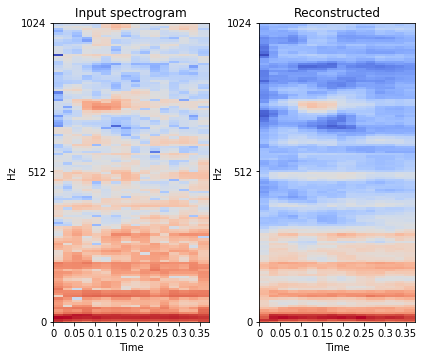

In [69]:
import librosa 
import matplotlib.pyplot as plt
import librosa.display 

for images, labels in train_dl: 
    print("spectrogram shape: ", images.shape)
    out = autoencoder(images)
    print("output shape: ", out.shape)
    break 
    
img = out[1][0].detach().cpu()
print(img.shape) 
import matplotlib.pyplot as plt 
fig, axs = plt.subplots(1,2,figsize = (6,5))
fig.tight_layout(pad=2.0)

img = img.numpy()

xt  = librosa.power_to_db(img)
print(np.max(img),np.min(img))
print(np.max(xt), np.min(xt))
xt1 = images[1][0].detach().cpu().numpy()
axs[1].set_title("Reconstructed")
axs[0].set_title("Input spectrogram")
librosa.display.specshow(xt1, y_axis = "mel",x_axis = "time", fmax = 1024, ax = axs[0])
librosa.display.specshow(img, y_axis = "mel",x_axis= "time", fmax = 1024, ax = axs[1])


In [61]:
out_list = [[] for i in range(3)]
imgs = [[] for i in range(3)]
mse_per_image = nn.MSELoss(reduction='none')
for images, labels in test_dl:
    print(images.shape)
    out = autoencoder(images)
    losses = torch.sum(mse_per_image(images, out).detach().cpu(), dim =(1,2,3))/(images.shape[-1]*images.shape[-2])
    losses = losses.numpy()
    for i in range(len(images)):
        out_list[int(labels[i].detach().cpu())].append(losses[i])
        imgs[int(labels[i].detach().cpu())].append(images[i])


torch.Size([150, 1, 128, 16])
torch.Size([150, 1, 128, 16])
torch.Size([150, 1, 128, 16])
torch.Size([150, 1, 128, 16])


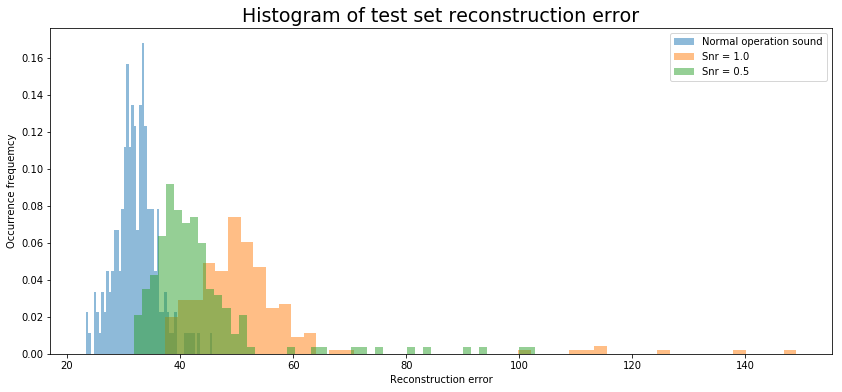

torch.Size([1, 128, 16])


In [62]:

fig, ax = plt.subplots(1,1,figsize = (14,6))

ax.title.set_text("Histogram of test set reconstruction error")
ax.title.set_fontsize(19)
labels = ["Normal operation sound", "Snr = 1.0", "Snr = 0.5"]

for i in range(len(out_list)):
    ax.hist(bins = 50, x=out_list[i], alpha = 0.5, label = labels[i], density = True)

ax.set_xlabel("Reconstruction error")
ax.set_ylabel("Occurrence frequemcy")
ax.legend()
plt.show()

min_img = imgs[1][out_list[1].index(min(out_list[1]))]
print(np.shape(min_img))


torch.Size([1, 128, 16])
(128, 16)


TypeError: colorbar() missing 1 required positional argument: 'mappable'

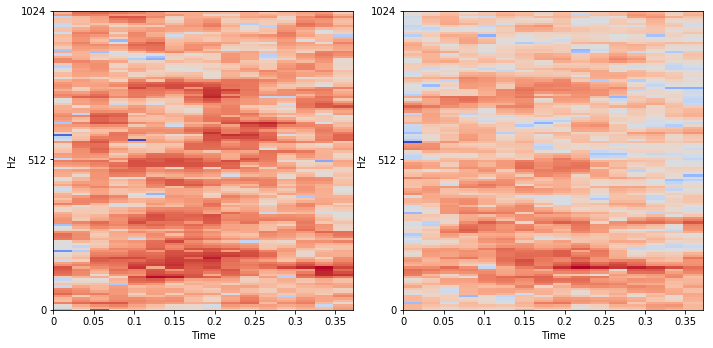

In [73]:
index_list = sorted(range(len(out_list[1])), key=lambda k: out_list[1][k])
min_img = imgs[1][index_list[2]]
min_img1 = imgs[1][index_list[0]]
fig, axs = plt.subplots(1,2,figsize = (10,5))
fig.tight_layout(pad=2.0)
print(np.shape(min_img))
im = min_img.detach().cpu().squeeze().numpy()

im1 = min_img1.detach().cpu().squeeze().numpy()

print(np.shape(im))
librosa.display.specshow(im, y_axis = "mel",x_axis= "time", fmax = 1024, ax = axs[0])
librosa.display.specshow(im1, y_axis = "mel",x_axis= "time", fmax = 1024, ax = axs[1])
fig.colorbar()


The difference is 0.07566094638182196


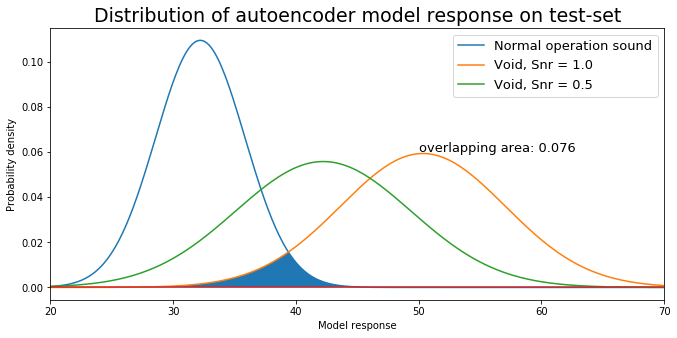

In [15]:
import scipy.integrate
from scipy.stats import norm
fig, ax = plt.subplots(1,1,figsize = (11,5))
integrate = scipy.integrate.quad
ax.title.set_text("Distribution of autoencoder model response on test-set")
ax.title.set_fontsize(19)
labels = ["Normal operation sound", "Void, Snr = 1.0", "Void, Snr = 0.5"]
x = np.linspace(20,140,800)
SMALL_SIZE = 13
MEDIUM_SIZE = 13
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
 
for i in range(len(out_list)):
    truncated = [out_list[i][j] if out_list[i][j]<=65 else 65 for j in range(len(out_list[i]))]
    if i ==1: 
        m_old = m
        s_old = s
        y_old = y
    m = np.mean(truncated)
    s = np.sqrt(np.var(truncated))
    y = norm.pdf(x,m,s)

    if i==1:
        under_fun = lambda x: min(norm.pdf(x,m,s), norm.pdf(x,m_old, s_old))
        diff = integrate(under_fun, 10,60)
        print(f"The difference is {diff[0]}")
        y_min = [min(y[i],y_old[i]) for i in range(len(y))]
        ax.fill_between(x, y_min)
    ax.plot(x,y, label = labels[i])
    


ax.plot(x, [0 for i in range(len(x))])
ax.set_xlim([20,70])
ax.set_xlabel("Model response")
ax.set_ylabel("Probability density")
ax.text(50,0.06,f"overlapping area: {diff[0]:.3f}")
ax.legend()
plt.show()


The aoc score is 0.995 for snr =1
The aoc score is 0.942 for snr =0.5


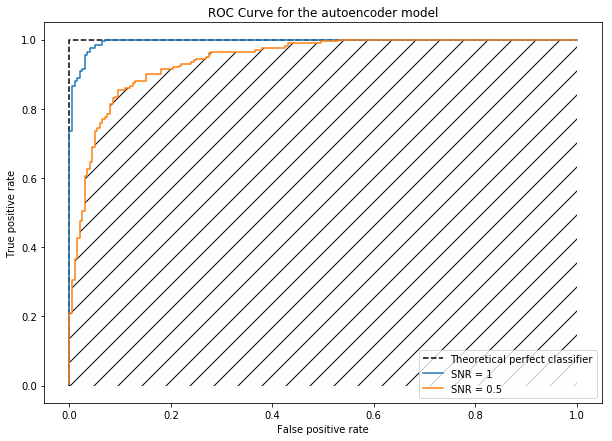

In [76]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

scores1 = out_list[0]+out_list[1]
y1 = [0 for i in range(len(out_list[0]))]+[1 for i in range(len(out_list[1]))]
fpr1, tpr1, thresholds1 = roc_curve(y1, scores1, pos_label = 1)

aoc_snr1 = roc_auc_score(y1,scores1)
print(f"The aoc score is {aoc_snr1:.3f} for snr =1")

scores2 = out_list[0]+out_list[2]
y2 = [0 for i in range(len(out_list[0]))]+[1 for i in range(len(out_list[2]))]
fpr2, tpr2, thresholds2= roc_curve(y2, scores2, pos_label = 1)

aoc_snr2 = roc_auc_score(y2,scores2)
print(f"The aoc score is {aoc_snr2:.3f} for snr =0.5")

fig, ax = plt.subplots(1,1, figsize = (10,7))

ax.title.set_text("ROC Curve for the autoencoder model")
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.plot(fpr1,[0]+[1 for i in range(len(fpr1)-1)],linestyle = "dashed", markersize = 7, label = "Theoretical perfect classifier", c = "black")

ax.plot(fpr1, tpr1, label = "SNR = 1")
ax.plot(fpr2, tpr2, label = "SNR = 0.5")
ax.fill_between(fpr2, tpr2, hatch = "/", alpha = 0.01)

ax.legend()

In [65]:
import librosa

test_piece, sr = librosa.load("./data/synthetic/7_with_void.wav")

score = []
i =0 
my_len = 16*512-1
while i<len(test_piece)-my_len:
    piece = test_piece[i:i+my_len]
    xt  = librosa.power_to_db(librosa.feature.melspectrogram(piece, n_mels = 128, fmax = 1024))
    xt = torch.tensor(xt).float()
    xt = torch.unsqueeze(xt,0)
    xt = torch.unsqueeze(xt,0)
    xt = xt.to(device)
    recons = autoencoder(xt)
    loss = mse_per_image(recons, xt)
    
    score.append(float(torch.sum(loss.detach().cpu())/(xt.shape[-1]*xt.shape[-2])))
    i+= 512
    


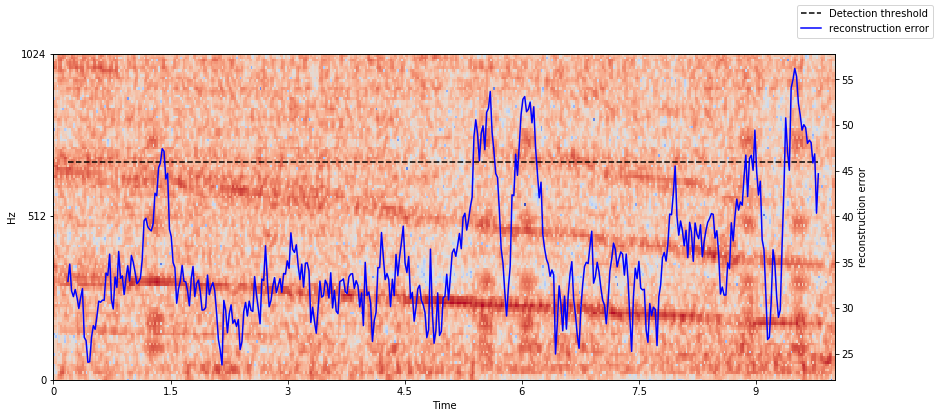

In [75]:
import librosa.display
x =[]
test_xt = librosa.power_to_db(librosa.feature.melspectrogram(test_piece, n_mels =128, fmax= 1024))
fig = plt.gcf()
fig.set_size_inches(14,6)
ax = plt.subplot()

ax2 = ax.twinx()
librosa.display.specshow(test_xt, fmax = 1024, y_axis = "mel", ax = ax, x_axis = 'time')
for i in range(len(score)):
    x.append((i+8)*(512/sr))
ax2.set_ylabel("reconstruction error")
ax2.plot(x,[46 for i in range(len(x))],linestyle = "dashed", markersize = 7, label = "Detection threshold", c = "black")
ax2.plot(x,score, c="blue", label = "reconstruction error")
fig.legend()

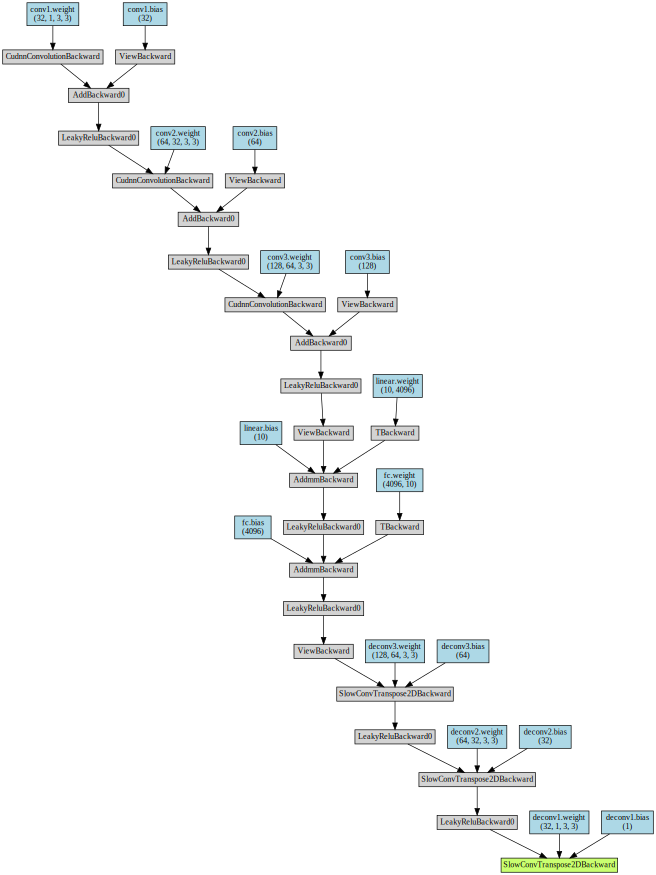

In [161]:
from torchviz import make_dot 
make_dot(recons, params = dict(autoencoder.named_parameters()))

In [163]:
from torch.utils.tensorboard import SummaryWriter 
writer = SummaryWriter("runs/ae_experiment_1")

In [169]:
writer.add_graph(autoencoder,images)
